In [1]:
#import stuff

%load_ext autoreload
%autoreload 2

import sys
#change path to wherever you put the code
sys.path.insert(0, '/Users/JacquelineYau/cnn/cs231n-final-project/ProcessingPack_Organoids/processingpack')

from copy import deepcopy
from pathlib import Path

import numpy as np
import skimage
from skimage import measure
import pandas as pd
import matplotlib.pyplot as pl

import ast
import operator

import chip
import experiment as exp
import chipcollections as collections
from org_extension import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
#define square finder
import sys
PY3 = sys.version_info[0] == 3

# Python 2/3 compatibility
if PY3:
    xrange = range

import numpy as np
from scipy import spatial as sp
import cv2 as cv
from matplotlib import pyplot as plt

def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def find_squares(img):
    img = cv.GaussianBlur(img, (25, 25), 0)
    squares = []
    for gray in cv.split(img):
        #thrs = 130
        for thrs in xrange(0, 255, 26):
            if thrs == 0:
                bin = cv.Canny(gray, 0, 50, apertureSize=5)
                bin = cv.dilate(bin, None)
            else:
                #bin = cv.adaptiveThreshold(gray, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
                _retval, bin = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
            bin, contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv.arcLength(cnt, True)
                cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv.contourArea(cnt) > 1000 and cv.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in xrange(4)])
                    if max_cos < 0.1:
                        squares.append(cnt)
    return squares

In [3]:
#define html table writers for summarizing data

def html_header(output_html):
    with open(output_html, "w") as out:
        header = '''
        <html>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.0/css/bootstrap.min.css">
        <link rel="stylesheet" href="https://cdn.datatables.net/1.10.19/css/jquery.dataTables.min.css">
        <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script src="https://cdn.datatables.net/1.10.19/js/jquery.dataTables.min.js"></script>
        <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.4.0/js/bootstrap.min.js"></script>

        <script>
        $(document).ready(function () {
        $('#microwell-data').DataTable();
        });
        </script>

        <table id="microwell-data" class="table table-striped table-bordered table-sm" cellspacing="0" width="100%">
        <thead>
        <tr>
        <th>well_id</th><th>day</th><th>median pixel intensity</th><th>hyst1 area</th><th>hyst2 area</th>
        <th>well</th><th>mw_area</th><th>hyst1</th><th>hyst2</th>
        </tr>
        </thead>
        <tbody>
        '''
        out.write(header)
        
def html_row(well,day,median,sum1,sum2,output_html):
    with open(output_html, "a") as output:
        row = '''
        <tr>
            <td>well{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_well.png alt = well{0:04d}_day{1:02d}_well.png></td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_mw_area.png alt = well{0:04d}_day{1:02d}_mw_area.png></td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_hyst1.png alt = well{0:04d}_day{1:02d}_hyst1.png></td>
            <td><img src = ./microwells/well{0:04d}_day{1:02d}_hyst2.png alt = well{0:04d}_day{1:02d}_hyst2.png></td>

        </tr>
        '''.format(well,day,median,sum1,sum2)
        output.write(row)
        
        
def html_footer(output_html):
    with open(output_html, "a") as file:
        footer = '''
        </tbody></table>
        </html>
        '''
        file.write(footer)

In [14]:
#set corner positions (from stitched image, find largest rectangle of fully enclosed subgrids, see example)
# format is oc[day] = ((top left), (top right), (bottom left), (bottom right))

oc = {}

#oc[0] = ((1043,3839), (12821,5267), (224,11562), (11953,12910))
oc[0] = ((1184, 3240), (21104, 3544), (1096, 15056), (20960, 15336))
oc[1] = ((1070,3771), (12846,5204), (246,11494), (11976,12844))
#oc[2] = ((979,3538), (12759,4939), (175,11256), (11900,12591))  #for gem_high
oc[2] = ((1200, 576), (21204, 684), (1104, 15600), (20976, 15336)) #For gem_low
oc[3] = ((982,3545), (12761,4949), (175,11266), (11900,12596))
oc[4] = ((975,3547), (12753,4948), (165,11269), (11895,12602))
oc[5] = ((984,3549), (12763,4950), (176,11271), (11901,12600))
oc[6] = ((978,3542), (12759,4953), (168,11269), (11901,12602))
oc[7] = ((760, 3236), (20680, 3532), (688, 15052), (20544, 15316))
#oc[7] = ((1222,3700), (12995,5138), (397,11415), (12135,12776))
oc[8] = ((1223,3694), (12999,5134), (398,11419), (12135,12771))
oc[9] = ((240, 9081), (20148, 8937), (1290, 20292), (21060, 18972))
oc[10] = ((744, 3224), (20680, 3480), (680, 15004), (20536, 15272))  #Used as alignment, Gem_low 
oc[11] = ((248, 9100), (19448, 9227), (1464, 20091), (20360, 19048))
oc[12] = ((240, 9111), (19440, 9213), (1368, 18885), (20376, 19029))
oc[13] = ((1056, 8960), (19480, 8894), (1048, 16750), (19656, 16854))
#oc[14] = ((1368, 2500), (19696, 2508), (1488, 16456), (19656, 16452))  #For gem_high
#oc[14] =((1212, 522), (21216, 684), (1104, 15264), (20964, 15516))  #For gem_low
oc[14] = ((1200, 576), (21204, 684), (1104, 15600), (20976, 15336))
oc[15] = ((1160, 2500), (19704, 2492), (1288, 16276), (19648, 16252))
oc[16] = ((760, 2252), (19504, 2148), (816, 14628), (19584, 14556))
oc[17] = ((576, 2292), (19312, 2356), (544, 11972), (19520, 11988))
oc[18] = ((616, 296), (20624, 312), (600, 15488), (20488, 15472))
oc[19] = ((1114, 2220), (19504, 2124), (1296, 17700), (19520, 17828))
oc[20] = ((928, 2052), (19496, 2132), (920, 15820), (19512, 15868))#this is the trypan image

In [15]:
#rotate images, then save .tif and .csv files of subgrids
from datetime import datetime

subarray_dims = (5,3) #number of col,row in the fully enclosed rectangle you selected (each subgrid counts as one, so in the example image this would be 5col,3row)

#these can stay the same
tile_dims = (20, 20) 
channel = '2bf'
exposure = 10
date = datetime(2019, 5, 7)
well = 1 

timecourse_length = 1 #0 indexed Original: 21
day = 7
#for day in range(timecourse_length):
#change paths to directory containing stitched images and/or code
srcHandle = Path('/Volumes/Jacqueline_Drive/cs231n/Data/Gem_low/day{0}_stitched.tif'.format(day))
targetHandle = Path('/Volumes/Jacqueline_Drive/cs231n/Data/Gem_low/day{0}_stitched_rotated.tif'.format(day))
rot_img = readAndRotateImg(srcHandle, oc[day], subarray_dims, targetHandle = targetHandle)
rot_corners = transformCorners(readTiff(srcHandle), rot_img, oc[day])
divisions = getPartitions(rot_corners, subarray_dims)
root = '/Volumes/Jacqueline_Drive/cs231n/Data/Gem_low/'
description = 'Day{0}'.format(day)
operator = 'AS'
chip.ChipImage.stampWidth = 194
e = exp.Experiment(description, root, operator) 
pinlist_path = '/Users/JacquelineYau/cnn/Code/ProcessingPack_Organoids/Pinlist/20x20_pinlist.csv'
pinlist = e.read_pinlist(pinlist_path)
arrayRepo = processTiles(str(targetHandle), e, pinlist, divisions, tile_dims, subarray_dims, channel, exposure, date = date, well = well, desc = e.info)
outRoot = Path('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low')

ar = arrayRepo[0, 0] 
hashStr = generateWellIdentifier(ar)
summary_imgPath = outRoot.joinpath('{}.tif'.format(hashStr))
summary_csvPath = outRoot.joinpath('{}.csv'.format(hashStr))

summaryDF = summarizeArrayRepo(arrayRepo)
summaryDF.to_csv(summary_csvPath)
writeSubArraySummaryImg(arrayRepo, summary_imgPath)

INFO     Experiment Initialized | Description: Day7, Operator: AS
INFO     Experiment Initialized | Description: Day7, Operator: AS
INFO     Experiment Initialized | Description: Day7, Operator: AS
INFO     Added Device | Device: FordyceLab, s1, d1.0.0
INFO     Added Device | Device: FordyceLab, s1, d1.0.0
INFO     Added Device | Device: FordyceLab, s1, d1.0.0
INFO     Added Device | Device: FordyceLab, s1, d1.0.1
INFO     Added Device | Device: FordyceLab, s1, d1.0.1
INFO     Added Device | Device: FordyceLab, s1, d1.0.1
INFO     Added Device | Device: FordyceLab, s1, d1.0.2
INFO     Added Device | Device: FordyceLab, s1, d1.0.2
INFO     Added Device | Device: FordyceLab, s1, d1.0.2
INFO     Added Device | Device: FordyceLab, s1, d1.0.3
INFO     Added Device | Device: FordyceLab, s1, d1.0.3
INFO     Added Device | Device: FordyceLab, s1, d1.0.3
INFO     Added Device | Device: FordyceLab, s1, d1.0.4
INFO     Added Device | Device: FordyceLab, s1, d1.0.4
INFO     Added Device | Device: 

Length total:  6000
well 0 day 7
well 1 day 7
well 2 day 7
well 3 day 7
well 4 day 7
well 5 day 7
well 6 day 7
well 7 day 7
well 8 day 7
well 9 day 7
well 10 day 7
well 11 day 7
well 12 day 7
well 13 day 7
well 14 day 7
well 15 day 7
well 16 day 7
well 17 day 7
well 18 day 7
well 19 day 7
well 20 day 7
well 21 day 7
well 22 day 7
well 23 day 7
well 24 day 7
well 25 day 7
well 26 day 7
well 27 day 7
well 28 day 7
well 29 day 7
well 30 day 7
well 31 day 7
well 32 day 7
well 33 day 7
well 34 day 7
well 35 day 7
well 36 day 7
well 37 day 7
well 38 day 7
well 39 day 7
well 40 day 7
well 41 day 7
well 42 day 7
well 43 day 7
well 44 day 7
well 45 day 7
well 46 day 7
well 47 day 7
well 48 day 7
well 49 day 7
well 50 day 7
well 51 day 7
well 52 day 7
well 53 day 7
well 54 day 7
well 55 day 7
well 56 day 7
well 57 day 7
well 58 day 7
well 59 day 7
well 60 day 7
well 61 day 7
well 62 day 7
well 63 day 7
well 64 day 7
well 65 day 7
well 66 day 7
well 67 day 7
well 68 day 7
well 69 day 7
well 70 da

well 553 day 7
well 554 day 7
well 555 day 7
well 556 day 7
well 557 day 7
well 558 day 7
well 559 day 7
well 560 day 7
well 561 day 7
well 562 day 7
well 563 day 7
well 564 day 7
well 565 day 7
well 566 day 7
well 567 day 7
well 568 day 7
well 569 day 7
well 570 day 7
well 571 day 7
well 572 day 7
well 573 day 7
well 574 day 7
well 575 day 7
well 576 day 7
well 577 day 7
well 578 day 7
well 579 day 7
well 580 day 7
well 581 day 7
well 582 day 7
well 583 day 7
well 584 day 7
well 585 day 7
well 586 day 7
well 587 day 7
well 588 day 7
well 589 day 7
well 590 day 7
well 591 day 7
well 592 day 7
well 593 day 7
well 594 day 7
well 595 day 7
well 596 day 7
well 597 day 7
well 598 day 7
well 599 day 7
well 600 day 7
well 601 day 7
well 602 day 7
well 603 day 7
well 604 day 7
well 605 day 7
well 606 day 7
well 607 day 7
well 608 day 7
well 609 day 7
well 610 day 7
well 611 day 7
well 612 day 7
well 613 day 7
well 614 day 7
well 615 day 7
well 616 day 7
well 617 day 7
well 618 day 7
well 619 d

well 1095 day 7
well 1096 day 7
well 1097 day 7
well 1098 day 7
well 1099 day 7
well 1100 day 7
well 1101 day 7
well 1102 day 7
well 1103 day 7
well 1104 day 7
well 1105 day 7
well 1106 day 7
well 1107 day 7
well 1108 day 7
well 1109 day 7
well 1110 day 7
well 1111 day 7
well 1112 day 7
well 1113 day 7
well 1114 day 7
well 1115 day 7
well 1116 day 7
well 1117 day 7
well 1118 day 7
well 1119 day 7
well 1120 day 7
well 1121 day 7
well 1122 day 7
well 1123 day 7
well 1124 day 7
well 1125 day 7
well 1126 day 7
well 1127 day 7
well 1128 day 7
well 1129 day 7
well 1130 day 7
well 1131 day 7
well 1132 day 7
well 1133 day 7
well 1134 day 7
well 1135 day 7
well 1136 day 7
well 1137 day 7
well 1138 day 7
well 1139 day 7
well 1140 day 7
well 1141 day 7
well 1142 day 7
well 1143 day 7
well 1144 day 7
well 1145 day 7
well 1146 day 7
well 1147 day 7
well 1148 day 7
well 1149 day 7
well 1150 day 7
well 1151 day 7
well 1152 day 7
well 1153 day 7
well 1154 day 7
well 1155 day 7
well 1156 day 7
well 115

well 1608 day 7
well 1609 day 7
well 1610 day 7
well 1611 day 7
well 1612 day 7
well 1613 day 7
well 1614 day 7
well 1615 day 7
well 1616 day 7
well 1617 day 7
well 1618 day 7
well 1619 day 7
well 1620 day 7
well 1621 day 7
well 1622 day 7
well 1623 day 7
well 1624 day 7
well 1625 day 7
well 1626 day 7
well 1627 day 7
well 1628 day 7
well 1629 day 7
well 1630 day 7
well 1631 day 7
well 1632 day 7
well 1633 day 7
well 1634 day 7
well 1635 day 7
well 1636 day 7
well 1637 day 7
well 1638 day 7
well 1639 day 7
well 1640 day 7
well 1641 day 7
well 1642 day 7
well 1643 day 7
well 1644 day 7
well 1645 day 7
well 1646 day 7
well 1647 day 7
well 1648 day 7
well 1649 day 7
well 1650 day 7
well 1651 day 7
well 1652 day 7
well 1653 day 7
well 1654 day 7
well 1655 day 7
well 1656 day 7
well 1657 day 7
well 1658 day 7
well 1659 day 7
well 1660 day 7
well 1661 day 7
well 1662 day 7
well 1663 day 7
well 1664 day 7
well 1665 day 7
well 1666 day 7
well 1667 day 7
well 1668 day 7
well 1669 day 7
well 167

well 2122 day 7
well 2123 day 7
well 2124 day 7
well 2125 day 7
well 2126 day 7
well 2127 day 7
well 2128 day 7
well 2129 day 7
well 2130 day 7
well 2131 day 7
well 2132 day 7
well 2133 day 7
well 2134 day 7
well 2135 day 7
well 2136 day 7
well 2137 day 7
well 2138 day 7
well 2139 day 7
well 2140 day 7
well 2141 day 7
well 2142 day 7
well 2143 day 7
well 2144 day 7
well 2145 day 7
well 2146 day 7
well 2147 day 7
well 2148 day 7
well 2149 day 7
well 2150 day 7
well 2151 day 7
well 2152 day 7
well 2153 day 7
well 2154 day 7
well 2155 day 7
well 2156 day 7
well 2157 day 7
well 2158 day 7
well 2159 day 7
well 2160 day 7
well 2161 day 7
well 2162 day 7
well 2163 day 7
well 2164 day 7
well 2165 day 7
well 2166 day 7
well 2167 day 7
well 2168 day 7
well 2169 day 7
well 2170 day 7
well 2171 day 7
well 2172 day 7
well 2173 day 7
well 2174 day 7
well 2175 day 7
well 2176 day 7
well 2177 day 7
well 2178 day 7
well 2179 day 7
well 2180 day 7
well 2181 day 7
well 2182 day 7
well 2183 day 7
well 218

well 2635 day 7
well 2636 day 7
well 2637 day 7
well 2638 day 7
well 2639 day 7
well 2640 day 7
well 2641 day 7
well 2642 day 7
well 2643 day 7
well 2644 day 7
well 2645 day 7
well 2646 day 7
well 2647 day 7
well 2648 day 7
well 2649 day 7
well 2650 day 7
well 2651 day 7
well 2652 day 7
well 2653 day 7
well 2654 day 7
well 2655 day 7
well 2656 day 7
well 2657 day 7
well 2658 day 7
well 2659 day 7
well 2660 day 7
well 2661 day 7
well 2662 day 7
well 2663 day 7
well 2664 day 7
well 2665 day 7
well 2666 day 7
well 2667 day 7
well 2668 day 7
well 2669 day 7
well 2670 day 7
well 2671 day 7
well 2672 day 7
well 2673 day 7
well 2674 day 7
well 2675 day 7
well 2676 day 7
well 2677 day 7
well 2678 day 7
well 2679 day 7
well 2680 day 7
well 2681 day 7
well 2682 day 7
well 2683 day 7
well 2684 day 7
well 2685 day 7
well 2686 day 7
well 2687 day 7
well 2688 day 7
well 2689 day 7
well 2690 day 7
well 2691 day 7
well 2692 day 7
well 2693 day 7
well 2694 day 7
well 2695 day 7
well 2696 day 7
well 269

well 3149 day 7
well 3150 day 7
well 3151 day 7
well 3152 day 7
well 3153 day 7
well 3154 day 7
well 3155 day 7
well 3156 day 7
well 3157 day 7
well 3158 day 7
well 3159 day 7
well 3160 day 7
well 3161 day 7
well 3162 day 7
well 3163 day 7
well 3164 day 7
well 3165 day 7
well 3166 day 7
well 3167 day 7
well 3168 day 7
well 3169 day 7
well 3170 day 7
well 3171 day 7
well 3172 day 7
well 3173 day 7
well 3174 day 7
well 3175 day 7
well 3176 day 7
well 3177 day 7
well 3178 day 7
well 3179 day 7
well 3180 day 7
well 3181 day 7
well 3182 day 7
well 3183 day 7
well 3184 day 7
well 3185 day 7
well 3186 day 7
well 3187 day 7
well 3188 day 7
well 3189 day 7
well 3190 day 7
well 3191 day 7
well 3192 day 7
well 3193 day 7
well 3194 day 7
well 3195 day 7
well 3196 day 7
well 3197 day 7
well 3198 day 7
well 3199 day 7
well 3200 day 7
well 3201 day 7
well 3202 day 7
well 3203 day 7
well 3204 day 7
well 3205 day 7
well 3206 day 7
well 3207 day 7
well 3208 day 7
well 3209 day 7
well 3210 day 7
well 321

well 3663 day 7
well 3664 day 7
well 3665 day 7
well 3666 day 7
well 3667 day 7
well 3668 day 7
well 3669 day 7
well 3670 day 7
well 3671 day 7
well 3672 day 7
well 3673 day 7
well 3674 day 7
well 3675 day 7
well 3676 day 7
well 3677 day 7
well 3678 day 7
well 3679 day 7
well 3680 day 7
well 3681 day 7
well 3682 day 7
well 3683 day 7
well 3684 day 7
well 3685 day 7
well 3686 day 7
well 3687 day 7
well 3688 day 7
well 3689 day 7
well 3690 day 7
well 3691 day 7
well 3692 day 7
well 3693 day 7
well 3694 day 7
well 3695 day 7
well 3696 day 7
well 3697 day 7
well 3698 day 7
well 3699 day 7
well 3700 day 7
well 3701 day 7
well 3702 day 7
well 3703 day 7
well 3704 day 7
well 3705 day 7
well 3706 day 7
well 3707 day 7
well 3708 day 7
well 3709 day 7
well 3710 day 7
well 3711 day 7
well 3712 day 7
well 3713 day 7
well 3714 day 7
well 3715 day 7
well 3716 day 7
well 3717 day 7
well 3718 day 7
well 3719 day 7
well 3720 day 7
well 3721 day 7
well 3722 day 7
well 3723 day 7
well 3724 day 7
well 372

well 4178 day 7
well 4179 day 7
well 4180 day 7
well 4181 day 7
well 4182 day 7
well 4183 day 7
well 4184 day 7
well 4185 day 7
well 4186 day 7
well 4187 day 7
well 4188 day 7
well 4189 day 7
well 4190 day 7
well 4191 day 7
well 4192 day 7
well 4193 day 7
well 4194 day 7
well 4195 day 7
well 4196 day 7
well 4197 day 7
well 4198 day 7
well 4199 day 7
well 4200 day 7
well 4201 day 7
well 4202 day 7
well 4203 day 7
well 4204 day 7
well 4205 day 7
well 4206 day 7
well 4207 day 7
well 4208 day 7
well 4209 day 7
well 4210 day 7
well 4211 day 7
well 4212 day 7
well 4213 day 7
well 4214 day 7
well 4215 day 7
well 4216 day 7
well 4217 day 7
well 4218 day 7
well 4219 day 7
well 4220 day 7
well 4221 day 7
well 4222 day 7
well 4223 day 7
well 4224 day 7
well 4225 day 7
well 4226 day 7
well 4227 day 7
well 4228 day 7
well 4229 day 7
well 4230 day 7
well 4231 day 7
well 4232 day 7
well 4233 day 7
well 4234 day 7
well 4235 day 7
well 4236 day 7
well 4237 day 7
well 4238 day 7
well 4239 day 7
well 424

well 4695 day 7
well 4696 day 7
well 4697 day 7
well 4698 day 7
well 4699 day 7
well 4700 day 7
well 4701 day 7
well 4702 day 7
well 4703 day 7
well 4704 day 7
well 4705 day 7
well 4706 day 7
well 4707 day 7
well 4708 day 7
well 4709 day 7
well 4710 day 7
well 4711 day 7
well 4712 day 7
well 4713 day 7
well 4714 day 7
well 4715 day 7
well 4716 day 7
well 4717 day 7
well 4718 day 7
well 4719 day 7
well 4720 day 7
well 4721 day 7
well 4722 day 7
well 4723 day 7
well 4724 day 7
well 4725 day 7
well 4726 day 7
well 4727 day 7
well 4728 day 7
well 4729 day 7
well 4730 day 7
well 4731 day 7
well 4732 day 7
well 4733 day 7
well 4734 day 7
well 4735 day 7
well 4736 day 7
well 4737 day 7
well 4738 day 7
well 4739 day 7
well 4740 day 7
well 4741 day 7
well 4742 day 7
well 4743 day 7
well 4744 day 7
well 4745 day 7
well 4746 day 7
well 4747 day 7
well 4748 day 7
well 4749 day 7
well 4750 day 7
well 4751 day 7
well 4752 day 7
well 4753 day 7
well 4754 day 7
well 4755 day 7
well 4756 day 7
well 475

well 5212 day 7
well 5213 day 7
well 5214 day 7
well 5215 day 7
well 5216 day 7
well 5217 day 7
well 5218 day 7
well 5219 day 7
well 5220 day 7
well 5221 day 7
well 5222 day 7
well 5223 day 7
well 5224 day 7
well 5225 day 7
well 5226 day 7
well 5227 day 7
well 5228 day 7
well 5229 day 7
well 5230 day 7
well 5231 day 7
well 5232 day 7
well 5233 day 7
well 5234 day 7
well 5235 day 7
well 5236 day 7
well 5237 day 7
well 5238 day 7
well 5239 day 7
well 5240 day 7
well 5241 day 7
well 5242 day 7
well 5243 day 7
well 5244 day 7
well 5245 day 7
well 5246 day 7
well 5247 day 7
well 5248 day 7
well 5249 day 7
well 5250 day 7
well 5251 day 7
well 5252 day 7
well 5253 day 7
well 5254 day 7
well 5255 day 7
well 5256 day 7
well 5257 day 7
well 5258 day 7
well 5259 day 7
well 5260 day 7
well 5261 day 7
well 5262 day 7
well 5263 day 7
well 5264 day 7
well 5265 day 7
well 5266 day 7
well 5267 day 7
well 5268 day 7
well 5269 day 7
well 5270 day 7
well 5271 day 7
well 5272 day 7
well 5273 day 7
well 527

well 5728 day 7
well 5729 day 7
well 5730 day 7
well 5731 day 7
well 5732 day 7
well 5733 day 7
well 5734 day 7
well 5735 day 7
well 5736 day 7
well 5737 day 7
well 5738 day 7
well 5739 day 7
well 5740 day 7
well 5741 day 7
well 5742 day 7
well 5743 day 7
well 5744 day 7
well 5745 day 7
well 5746 day 7
well 5747 day 7
well 5748 day 7
well 5749 day 7
well 5750 day 7
well 5751 day 7
well 5752 day 7
well 5753 day 7
well 5754 day 7
well 5755 day 7
well 5756 day 7
well 5757 day 7
well 5758 day 7
well 5759 day 7
well 5760 day 7
well 5761 day 7
well 5762 day 7
well 5763 day 7
well 5764 day 7
well 5765 day 7
well 5766 day 7
well 5767 day 7
well 5768 day 7
well 5769 day 7
well 5770 day 7
well 5771 day 7
well 5772 day 7
well 5773 day 7
well 5774 day 7
well 5775 day 7
well 5776 day 7
well 5777 day 7
well 5778 day 7
well 5779 day 7
well 5780 day 7
well 5781 day 7
well 5782 day 7
well 5783 day 7
well 5784 day 7
well 5785 day 7
well 5786 day 7
well 5787 day 7
well 5788 day 7
well 5789 day 7
well 579

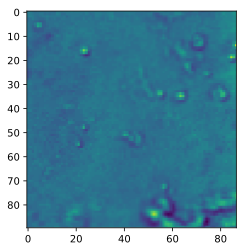

In [16]:
#separate subgrids into individual microwell images and save images, csv file, and html file
#also does some processing of the microwell images to calculate area of the cell/organoid within, you may or may not need this

from skimage import data, filters
import operator
from mpl_toolkits.axes_grid1 import make_axes_locatable
timecourse_length = 1 #0 indexed

#also saves csv and html files with values for each day
output_csv = '/Volumes/Jacqueline_Drive/cs231n/Data/Output/Stitched/Gem_low/well_summary.csv'
output_html = '/Volumes/Jacqueline_Drive/cs231n/Data/Output/Stitched/Gem_low/well_summary.html'
html_header(output_html)
with open(output_csv, "w") as out:
    header = 'well id' + ',' + 'day' + ',' + 'median pixel intensity' + ',' + 'hyst1 area' + ',' + 'hyst2 area' + "\n"
    out.write(header)   

#iterate through days
day = 7
#for day in range(timecourse_length):
#import csv and tif files you just saved above
reimport = pd.read_csv('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/Day{0}-1-20190507.csv'.format(day))
imagePath = '/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/Day{0}-1-20190507.tif'.format(day)
with skimage.external.tifffile.TiffFile(imagePath) as tif:
    data = tif.asarray()

#iterate through wells
K = 1000
#reimport originally
print("Length total: ", len(reimport))
for i in range(len(reimport)):
    #pull out well location from csv
    chamberInfo = reimport.iloc[i]
    #slice image to that well
    xslice = ast.literal_eval(chamberInfo.summaryImg_xslice)
    yslice = ast.literal_eval(chamberInfo.summaryImg_yslice)
    well = data[chamberInfo.stack_indexer][xslice[0]:xslice[1],yslice[0]:yslice[1]]
    pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/day7_samples/well{0:04d}_day{1:02d}_well.png'.format(i, day), well, cmap="gray")

    #use the square finder to find the inside of the well 
    squares = find_squares(well)
    squares = np.sort(np.array(squares))

    #find square with smallest perimeter and set that equal to inner mw_area
    perimeters = {}
    for x in range(len(squares)):
        perimeter = cv.arcLength(squares[x], True)
        perimeters[x] = perimeter
    if len(perimeters) == 0:
        print('perimeters not found')
    else:
        small_key = min(perimeters.items(), key=operator.itemgetter(1))[0]
        min_x = np.min(squares[small_key][:,0])
        max_x = np.max(squares[small_key][:,0])
        min_y = np.min(squares[small_key][:,1])
        max_y = np.max(squares[small_key][:,1])

        mw_area = well[min_x+5:max_x-5,min_y+5:max_y-5]
        pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/day7_samples/well{0:04d}_day{1:02d}_mw_area.png'.format(i, day), mw_area, cmap="gray")
        pl.imshow(mw_area)

        #normalize image by median pixel intensity
        filtermedian = np.abs(mw_area.astype(float) - np.median(mw_area))

        kernel =  cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))
        closing = cv.morphologyEx(filtermedian, cv.MORPH_CLOSE, kernel)
        hyst1 = skimage.filters.apply_hysteresis_threshold(closing, 15,10 )
        #pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/testing/well{0:04d}_day{1:02d}_hyst1.png'.format(i, day), hyst1.astype(float), cmap="gray")
        

        kernel =  cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
        opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)

        hyst2 = filters.apply_hysteresis_threshold(opening, 15,10 )
        #pl.imsave('/Volumes/Jacqueline_Drive/cs231n/Data/Output/Gem_low/testing/well{0:04d}_day{1:02d}_hyst2.png'.format(i, day), hyst2.astype(float), cmap="gray")
        
        with open(output_csv, "a") as output:
            line = str(i) + ',' + str(day) + ',' + str(np.median(mw_area)) + ',' + str(np.sum(hyst1)) + ',' + str(np.sum(hyst2)) + "\n"
            output.write(line)

        html_row(i,day,np.median(mw_area),np.sum(hyst1),np.sum(hyst2),output_html)


        print('well' + " " +  str(i) + " " + 'day' + " " + str(day))

html_footer(output_html)

In [3]:
#Try inputting whole img to find squares
img = '/Users/JacquelineYau/cnn/cs231n-final-project/Data/Gem_low/day7_stitched.tif'
with skimage.external.tifffile.TiffFile(img) as tif:
    data = tif.asarray()
print(data.shape, data[0])
squares = find_squares(data)
squares = np.sort(np.array(squares))
print(len(squares))

(20160, 22848) [ 88  77  70 ... 121 121 123]
5149


In [4]:
print(len(squares))
for i in range(len(squares)):
    print(squares[i].shape)
    mins = np.argmin(squares[i], axis=0)
    maxs = np.argmax(squares[i], axis=0)
    print(squares[i])
    mw_area = data[squares[i][mins[0]][0]:squares[i][maxs[0]][0],squares[i][mins[1]][1]:squares[i][maxs[1]][1]]
    pl.imsave('/Users/JacquelineYau/cnn/cs231n-final-project/Data/gem_low_day_7_thres_130/day0well%d.png' % (i + 1), mw_area, cmap="gray")
    #pl.imshow(mw_area)

5149
(4, 2)
[[10804 19854]
 [10803 19966]
 [10908 19968]
 [10911 19855]]
(4, 2)
[[10603 19852]
 [10599 19964]
 [10703 19970]
 [10709 19855]]
(4, 2)
[[10029 19850]
 [10026 19957]
 [10135 19961]
 [10136 19848]]
(4, 2)
[[10910 19844]
 [10913 19973]
 [10798 19970]
 [10798 19849]]
(4, 2)
[[10027 19841]
 [10144 19844]
 [10140 19965]
 [10022 19962]]
(4, 2)
[[13630 19664]
 [13621 19774]
 [13734 19780]
 [13736 19671]]
(4, 2)
[[13616 19667]
 [13732 19658]
 [13738 19784]
 [13622 19785]]
(4, 2)
[[12338 19659]
 [12339 19770]
 [12442 19773]
 [12448 19660]]
(4, 2)
[[12253 19655]
 [12146 19662]
 [12148 19770]
 [12254 19771]]
(4, 2)
[[12447 19648]
 [12452 19772]
 [12337 19777]
 [12329 19656]]
(4, 2)
[[12256 19647]
 [12261 19774]
 [12148 19778]
 [12139 19658]]
(4, 2)
[[ 6620 19589]
 [ 6623 19707]
 [ 6739 19705]
 [ 6740 19590]]
(4, 2)
[[ 6613 19586]
 [ 6744 19584]
 [ 6747 19702]
 [ 6612 19704]]
(4, 2)
[[ 5461 19571]
 [ 5456 19676]
 [ 5567 19684]
 [ 5572 19570]]
(4, 2)
[[ 5458 19563]
 [ 5580 19566]
 [ 557

(4, 2)
[[13055 17755]
 [13175 17758]
 [13171 17878]
 [13050 17869]]
(4, 2)
[[11959 17745]
 [11958 17858]
 [12061 17862]
 [12066 17749]]
(4, 2)
[[11767 17745]
 [11764 17855]
 [11871 17858]
 [11871 17743]]
(4, 2)
[[10820 17737]
 [10812 17851]
 [10918 17856]
 [10922 17743]]
(4, 2)
[[10615 17739]
 [10614 17854]
 [10717 17855]
 [10720 17743]]
(4, 2)
[[11954 17740]
 [12072 17743]
 [12070 17862]
 [11948 17857]]
(4, 2)
[[11763 17738]
 [11881 17742]
 [11872 17866]
 [11758 17858]]
(4, 2)
[[10811 17734]
 [10926 17735]
 [10923 17859]
 [10808 17856]]
(4, 2)
[[10609 17734]
 [10726 17739]
 [10724 17856]
 [10607 17856]]
(4, 2)
[[ 9854 17733]
 [ 9853 17844]
 [ 9958 17848]
 [ 9958 17734]]
(4, 2)
[[ 9477 17725]
 [ 9472 17838]
 [ 9576 17845]
 [ 9584 17736]]
(4, 2)
[[ 9851 17726]
 [ 9965 17731]
 [ 9961 17854]
 [ 9845 17845]]
(4, 2)
[[ 9272 17725]
 [ 9269 17835]
 [ 9374 17842]
 [ 9378 17730]]
(4, 2)
[[ 9473 17719]
 [ 9589 17731]
 [ 9581 17849]
 [ 9466 17840]]
(4, 2)
[[ 9268 17718]
 [ 9383 17725]
 [ 9383 178

(4, 2)
[[10237 16751]
 [10235 16859]
 [10341 16865]
 [10342 16750]]
(4, 2)
[[11012 16747]
 [11122 16750]
 [11120 16875]
 [11007 16871]]
(4, 2)
[[10613 16749]
 [10730 16751]
 [10726 16874]
 [10610 16866]]
(4, 2)
[[10236 16742]
 [10351 16751]
 [10346 16870]
 [10231 16864]]
(4, 2)
[[ 9481 16739]
 [ 9478 16855]
 [ 9582 16857]
 [ 9584 16746]]
(4, 2)
[[ 9272 16740]
 [ 9272 16851]
 [ 9378 16855]
 [ 9379 16742]]
(4, 2)
[[ 9470 16739]
 [ 9590 16743]
 [ 9585 16862]
 [ 9468 16854]]
(4, 2)
[[ 9266 16736]
 [ 9385 16738]
 [ 9381 16861]
 [ 9267 16853]]
(4, 2)
[[ 6633 16695]
 [ 6634 16805]
 [ 6754 16812]
 [ 6756 16698]]
(4, 2)
[[ 6629 16689]
 [ 6760 16692]
 [ 6763 16812]
 [ 6630 16808]]
(4, 2)
[[ 3387 16686]
 [ 3389 16795]
 [ 3497 16797]
 [ 3498 16688]]
(4, 2)
[[ 4181 16682]
 [ 4180 16794]
 [ 4283 16799]
 [ 4287 16685]]
(4, 2)
[[ 3000 16684]
 [ 3001 16796]
 [ 3109 16797]
 [ 3112 16688]]
(4, 2)
[[ 2803 16686]
 [ 2806 16794]
 [ 2917 16796]
 [ 2916 16685]]
(4, 2)
[[ 4175 16677]
 [ 4290 16679]
 [ 4292 168

(4, 2)
[[ 8379 15934]
 [ 8381 16042]
 [ 8487 16046]
 [ 8487 15933]]
(4, 2)
[[ 8887 15932]
 [ 9003 15937]
 [ 8999 16060]
 [ 8888 16058]]
(4, 2)
[[ 8697 15929]
 [ 8810 15933]
 [ 8810 16056]
 [ 8690 16045]]
(4, 2)
[[ 8190 15929]
 [ 8193 16043]
 [ 8297 16044]
 [ 8299 15933]]
(4, 2)
[[ 8377 15925]
 [ 8496 15933]
 [ 8495 16049]
 [ 8374 16044]]
(4, 2)
[[ 8186 15923]
 [ 8306 15930]
 [ 8303 16047]
 [ 8183 16041]]
(4, 2)
[[ 7790 15924]
 [ 7791 16031]
 [ 7898 16038]
 [ 7901 15928]]
(4, 2)
[[ 7214 15915]
 [ 7215 16020]
 [ 7325 16027]
 [ 7325 15914]]
(4, 2)
[[15904 18508]
 [16018 18506]
 [16020 18613]
 [15910 18616]]
(4, 2)
[[ 7214 15905]
 [ 7331 15910]
 [ 7328 16034]
 [ 7210 16024]]
(4, 2)
[[ 7024 15900]
 [ 7137 15906]
 [ 7138 16029]
 [ 7022 16023]]
(4, 2)
[[15898 18503]
 [15905 18621]
 [16023 18619]
 [16021 18499]]
(4, 2)
[[ 3490 15902]
 [ 3376 15900]
 [ 3380 16007]
 [ 3486 16010]]
(4, 2)
[[ 3764 15900]
 [ 3768 16008]
 [ 3877 16006]
 [ 3873 15896]]
(4, 2)
[[ 2393 15894]
 [ 2390 16003]
 [ 2501 160

(4, 2)
[[12386 15406]
 [12386 15514]
 [12493 15519]
 [12497 15408]]
(4, 2)
[[12194 15401]
 [12191 15509]
 [12299 15515]
 [12304 15404]]
(4, 2)
[[11985 15400]
 [11987 15510]
 [12108 15510]
 [12110 15400]]
(4, 2)
[[12382 15400]
 [12503 15404]
 [12496 15524]
 [12380 15518]]
(4, 2)
[[11794 15393]
 [11790 15503]
 [11902 15505]
 [11901 15396]]
(4, 2)
[[11978 15396]
 [12113 15394]
 [12117 15509]
 [11981 15513]]
(4, 2)
[[11601 15390]
 [11599 15502]
 [11710 15502]
 [11710 15395]]
(4, 2)
[[11792 15386]
 [11906 15391]
 [11900 15514]
 [11787 15509]]
(4, 2)
[[11410 15386]
 [11406 15497]
 [11516 15501]
 [11516 15392]]
(4, 2)
[[11215 15385]
 [11211 15491]
 [11321 15498]
 [11321 15385]]
(4, 2)
[[11596 15385]
 [11717 15392]
 [11710 15510]
 [11594 15505]]
(4, 2)
[[11408 15378]
 [11518 15382]
 [11515 15508]
 [11399 15498]]
(4, 2)
[[11213 15377]
 [11326 15381]
 [11327 15501]
 [11211 15501]]
(4, 2)
[[10625 15376]
 [10624 15485]
 [10734 15486]
 [10736 15381]]
(4, 2)
[[10623 15368]
 [10735 15370]
 [10738 154

(4, 2)
[[ 3479 14795]
 [ 3370 14799]
 [ 3375 14909]
 [ 3479 14909]]
(4, 2)
[[ 6044 14794]
 [ 6045 14906]
 [ 6150 14909]
 [ 6156 14799]]
(4, 2)
[[14792 18129]
 [14800 18250]
 [14921 18241]
 [14913 18125]]
(4, 2)
[[ 2198 14791]
 [ 2194 14902]
 [ 2306 14903]
 [ 2306 14796]]
(4, 2)
[[ 6428 14790]
 [ 6545 14799]
 [ 6540 14920]
 [ 6423 14910]]
(4, 2)
[[ 4268 14793]
 [ 4159 14795]
 [ 4161 14904]
 [ 4271 14901]]
(4, 2)
[[ 2005 14790]
 [ 2000 14899]
 [ 2109 14904]
 [ 2110 14792]]
(4, 2)
[[ 5655 14794]
 [ 5658 14901]
 [ 5769 14901]
 [ 5764 14790]]
(4, 2)
[[ 4782 14789]
 [ 4672 14796]
 [ 4677 14901]
 [ 4786 14898]]
(4, 2)
[[ 1808 14791]
 [ 1806 14898]
 [ 1918 14902]
 [ 1920 14792]]
(4, 2)
[[ 5462 14792]
 [ 5468 14903]
 [ 5574 14901]
 [ 5568 14788]]
(4, 2)
[[ 3370 14789]
 [ 3492 14798]
 [ 3482 14915]
 [ 3365 14908]]
(4, 2)
[[ 3179 14786]
 [ 3296 14795]
 [ 3295 14909]
 [ 3172 14909]]
(4, 2)
[[ 6043 14786]
 [ 6161 14793]
 [ 6157 14912]
 [ 6039 14908]]
(4, 2)
[[ 5652 14787]
 [ 5776 14792]
 [ 5769 149

(4, 2)
[[14373 16035]
 [14373 16169]
 [14489 16172]
 [14495 16043]]
(4, 2)
[[14363 15849]
 [14364 15958]
 [14491 15959]
 [14482 15841]]
(4, 2)
[[14358 15271]
 [14468 15268]
 [14473 15377]
 [14363 15379]]
(4, 2)
[[14352 15266]
 [14359 15385]
 [14479 15379]
 [14472 15263]]
(4, 2)
[[14349 14674]
 [14456 14675]
 [14460 14798]
 [14349 14795]]
(4, 2)
[[14344 14481]
 [14450 14478]
 [14457 14589]
 [14348 14593]]
(4, 2)
[[14339 14673]
 [14345 14802]
 [14464 14802]
 [14459 14668]]
(4, 2)
[[14335 14479]
 [14342 14597]
 [14461 14595]
 [14454 14473]]
(4, 2)
[[13903 14330]
 [13901 14442]
 [14011 14443]
 [14012 14336]]
(4, 2)
[[12925 14309]
 [12917 14422]
 [13029 14423]
 [13031 14317]]
(4, 2)
[[12917 14305]
 [13036 14311]
 [13028 14434]
 [12911 14425]]
(4, 2)
[[12210 14301]
 [12209 14408]
 [12317 14412]
 [12322 14303]]
(4, 2)
[[12002 14298]
 [12005 14407]
 [12129 14404]
 [12123 14296]]
(4, 2)
[[11807 14295]
 [11806 14400]
 [11916 14407]
 [11917 14293]]
(4, 2)
[[12207 14294]
 [12327 14299]
 [12319 144

(4, 2)
[[ 4865 13998]
 [ 4983 14003]
 [ 4978 14138]
 [ 4861 14131]]
(4, 2)
[[13973 15853]
 [14080 15851]
 [14085 15961]
 [13975 15962]]
(4, 2)
[[13968 15660]
 [14081 15662]
 [14081 15767]
 [13971 15769]]
(4, 2)
[[13965 15851]
 [13974 15969]
 [14093 15962]
 [14083 15845]]
(4, 2)
[[13959 15660]
 [13963 15770]
 [14088 15769]
 [14080 15652]]
(4, 2)
[[13960 15274]
 [14067 15270]
 [14073 15380]
 [13963 15381]]
(4, 2)
[[13957 15079]
 [14063 15076]
 [14069 15187]
 [13957 15185]]
(4, 2)
[[13952 15272]
 [13958 15385]
 [14078 15384]
 [14071 15264]]
(4, 2)
[[13953 14885]
 [14063 14886]
 [14067 14992]
 [13957 14996]]
(4, 2)
[[13951 15076]
 [13956 15194]
 [14072 15193]
 [14067 15072]]
(4, 2)
[[13947 14881]
 [13953 15002]
 [14072 14994]
 [14065 14881]]
(4, 2)
[[13943 14487]
 [14053 14485]
 [14056 14594]
 [13950 14597]]
(4, 2)
[[13942 14291]
 [14045 14289]
 [14054 14397]
 [13944 14402]]
(4, 2)
[[13944 14477]
 [13939 14596]
 [14060 14599]
 [14059 14482]]
(4, 2)
[[13935 14101]
 [14046 14099]
 [14049 142

(4, 2)
[[ 2792 13620]
 [ 2786 13728]
 [ 2898 13734]
 [ 2899 13623]]
(4, 2)
[[13618 17946]
 [13620 18060]
 [13743 18059]
 [13735 17940]]
(4, 2)
[[ 3368 13615]
 [ 3485 13622]
 [ 3482 13741]
 [ 3362 13736]]
(4, 2)
[[ 2192 13620]
 [ 2197 13730]
 [ 2305 13727]
 [ 2302 13616]]
(4, 2)
[[ 3945 13617]
 [ 4080 13621]
 [ 4080 13735]
 [ 3948 13741]]
(4, 2)
[[ 2977 13618]
 [ 3097 13619]
 [ 3095 13740]
 [ 2975 13734]]
(4, 2)
[[13617 17749]
 [13621 17871]
 [13741 17866]
 [13734 17749]]
(4, 2)
[[ 4269 13615]
 [ 4270 13736]
 [ 4153 13737]
 [ 4150 13618]]
(4, 2)
[[ 2784 13617]
 [ 2901 13616]
 [ 2900 13741]
 [ 2787 13738]]
(4, 2)
[[ 2004 13613]
 [ 2003 13728]
 [ 2109 13727]
 [ 2113 13620]]
(4, 2)
[[ 5652 13613]
 [ 5769 13618]
 [ 5765 13740]
 [ 5652 13738]]
(4, 2)
[[ 5575 13617]
 [ 5577 13735]
 [ 5461 13739]
 [ 5453 13617]]
(4, 2)
[[ 1806 13618]
 [ 1807 13723]
 [ 1921 13722]
 [ 1920 13616]]
(4, 2)
[[ 2184 13618]
 [ 2308 13612]
 [ 2312 13731]
 [ 2187 13729]]
(4, 2)
[[ 2001 13606]
 [ 2118 13614]
 [ 2109 137

(4, 2)
[[ 8380 13251]
 [ 8496 13256]
 [ 8492 13377]
 [ 8377 13375]]
(4, 2)
[[13255 18724]
 [13362 18726]
 [13363 18850]
 [13253 18849]]
(4, 2)
[[ 7596 13250]
 [ 7596 13360]
 [ 7703 13361]
 [ 7707 13253]]
(4, 2)
[[13249 18930]
 [13255 19048]
 [13376 19042]
 [13365 18924]]
(4, 2)
[[ 7403 13248]
 [ 7402 13357]
 [ 7511 13359]
 [ 7510 13247]]
(4, 2)
[[ 7213 13244]
 [ 7212 13357]
 [ 7318 13359]
 [ 7322 13249]]
(4, 2)
[[13243 18343]
 [13352 18337]
 [13357 18450]
 [13254 18453]]
(4, 2)
[[13245 18144]
 [13350 18144]
 [13354 18256]
 [13246 18257]]
(4, 2)
[[ 7399 13242]
 [ 7518 13246]
 [ 7512 13368]
 [ 7398 13362]]
(4, 2)
[[ 6822 13246]
 [ 6825 13352]
 [ 6935 13353]
 [ 6935 13244]]
(4, 2)
[[ 6618 13241]
 [ 6618 13351]
 [ 6741 13351]
 [ 6741 13240]]
(4, 2)
[[13241 18335]
 [13246 18456]
 [13365 18449]
 [13360 18335]]
(4, 2)
[[ 6230 13239]
 [ 6232 13349]
 [ 6342 13347]
 [ 6337 13237]]
(4, 2)
[[ 3669 13236]
 [ 3560 13241]
 [ 3560 13346]
 [ 3674 13343]]
(4, 2)
[[13236 18142]
 [13241 18263]
 [13362 182

(4, 2)
[[12417 12926]
 [12533 12922]
 [12537 13044]
 [12419 13044]]
(4, 2)
[[12224 12922]
 [12349 12928]
 [12341 13043]
 [12223 13038]]
(4, 2)
[[12017 12920]
 [12147 12917]
 [12147 13040]
 [12018 13037]]
(4, 2)
[[11448 12910]
 [11446 13023]
 [11550 13025]
 [11555 12918]]
(4, 2)
[[11251 12908]
 [11251 13018]
 [11356 13022]
 [11359 12910]]
(4, 2)
[[11058 12905]
 [11058 13017]
 [11162 13018]
 [11167 12909]]
(4, 2)
[[10864 12903]
 [10863 13013]
 [10972 13013]
 [10973 12905]]
(4, 2)
[[11053 12900]
 [11174 12907]
 [11168 13021]
 [11047 13014]]
(4, 2)
[[10655 12904]
 [10657 13010]
 [10777 13010]
 [10780 12903]]
(4, 2)
[[10857 12899]
 [10974 12896]
 [10979 13016]
 [10861 13020]]
(4, 2)
[[10652 12896]
 [10780 12894]
 [10782 13015]
 [10654 13015]]
(4, 2)
[[ 9693 12882]
 [ 9690 12995]
 [ 9799 12994]
 [ 9800 12887]]
(4, 2)
[[ 9501 12878]
 [ 9492 12987]
 [ 9601 12995]
 [ 9609 12887]]
(4, 2)
[[ 9687 12878]
 [ 9806 12883]
 [ 9802 13000]
 [ 9681 12994]]
(4, 2)
[[ 9098 12875]
 [ 9096 12986]
 [ 9204 129

(4, 2)
[[12575 14316]
 [12685 14308]
 [12692 14418]
 [12581 14419]]
(4, 2)
[[12572 14310]
 [12577 14425]
 [12696 14422]
 [12690 14304]]
(4, 2)
[[12560 13330]
 [12667 13328]
 [12671 13452]
 [12559 13451]]
(4, 2)
[[12556 13324]
 [12551 13452]
 [12676 13457]
 [12676 13328]]
(4, 2)
[[12549 12750]
 [12654 12748]
 [12659 12858]
 [12553 12860]]
(4, 2)
[[12432 12540]
 [12426 12648]
 [12536 12655]
 [12539 12546]]
(4, 2)
[[12234 12542]
 [12236 12649]
 [12344 12651]
 [12344 12540]]
(4, 2)
[[12428 12533]
 [12539 12542]
 [12537 12663]
 [12422 12654]]
(4, 2)
[[11834 12533]
 [11832 12639]
 [11943 12643]
 [11945 12535]]
(4, 2)
[[11643 12528]
 [11642 12639]
 [11751 12638]
 [11752 12534]]
(4, 2)
[[11832 12526]
 [11950 12530]
 [11947 12648]
 [11825 12642]]
(4, 2)
[[11452 12524]
 [11448 12634]
 [11556 12637]
 [11555 12526]]
(4, 2)
[[11638 12523]
 [11752 12523]
 [11752 12647]
 [11637 12642]]
(4, 2)
[[11449 12517]
 [11563 12524]
 [11561 12641]
 [11443 12638]]
(4, 2)
[[11063 12517]
 [11059 12626]
 [11167 126

(4, 2)
[[ 5176 12253]
 [ 5173 12376]
 [ 5055 12369]
 [ 5061 12251]]
(4, 2)
[[12246 17371]
 [12250 17501]
 [12369 17499]
 [12366 17368]]
(4, 2)
[[ 1816 12247]
 [ 1819 12361]
 [ 1924 12359]
 [ 1928 12251]]
(4, 2)
[[ 1622 12246]
 [ 1625 12357]
 [ 1733 12355]
 [ 1734 12246]]
(4, 2)
[[ 1814 12239]
 [ 1933 12245]
 [ 1926 12367]
 [ 1809 12359]]
(4, 2)
[[ 1619 12240]
 [ 1741 12244]
 [ 1733 12364]
 [ 1613 12354]]
(4, 2)
[[12235 16472]
 [12341 16469]
 [12347 16581]
 [12239 16580]]
(4, 2)
[[12229 16468]
 [12235 16586]
 [12353 16581]
 [12352 16470]]
(4, 2)
[[12224 15877]
 [12333 15875]
 [12337 15984]
 [12227 15987]]
(4, 2)
[[12216 15689]
 [12327 15680]
 [12335 15791]
 [12225 15794]]
(4, 2)
[[12216 15876]
 [12220 15988]
 [12344 15986]
 [12336 15870]]
(4, 2)
[[12215 15679]
 [12220 15799]
 [12335 15796]
 [12328 15673]]
(4, 2)
[[12207 15105]
 [12317 15102]
 [12321 15210]
 [12208 15209]]
(4, 2)
[[12203 15098]
 [12204 15215]
 [12328 15211]
 [12318 15095]]
(4, 2)
[[12197 14508]
 [12308 14512]
 [12306 146

(4, 2)
[[ 5657 11858]
 [ 5660 11964]
 [ 5770 11964]
 [ 5770 11855]]
(4, 2)
[[ 5068 11853]
 [ 5063 11961]
 [ 5173 11965]
 [ 5177 11854]]
(4, 2)
[[ 4275 11852]
 [ 4166 11853]
 [ 4163 11963]
 [ 4270 11965]]
(4, 2)
[[ 4355 11856]
 [ 4360 11965]
 [ 4466 11962]
 [ 4467 11851]]
(4, 2)
[[ 2910 11849]
 [ 2800 11852]
 [ 2802 11962]
 [ 2910 11960]]
(4, 2)
[[ 2595 11848]
 [ 2594 11960]
 [ 2715 11962]
 [ 2717 11848]]
(4, 2)
[[ 5657 11848]
 [ 5777 11852]
 [ 5770 11971]
 [ 5652 11965]]
(4, 2)
[[ 5064 11848]
 [ 5182 11850]
 [ 5176 11971]
 [ 5060 11967]]
(4, 2)
[[ 4167 11844]
 [ 4279 11847]
 [ 4278 11967]
 [ 4160 11967]]
(4, 2)
[[ 4471 11847]
 [ 4474 11964]
 [ 4357 11969]
 [ 4355 11848]]
(4, 2)
[[ 2801 11841]
 [ 2918 11848]
 [ 2914 11965]
 [ 2793 11962]]
(4, 2)
[[ 2587 11847]
 [ 2721 11843]
 [ 2724 11962]
 [ 2590 11966]]
(4, 2)
[[11838 16994]
 [11947 16988]
 [11951 17099]
 [11843 17101]]
(4, 2)
[[11835 16799]
 [11948 16799]
 [11944 16909]
 [11836 16902]]
(4, 2)
[[11834 16988]
 [11838 17105]
 [11958 171

(4, 2)
[[ 8922 11500]
 [ 8925 11612]
 [ 9027 11612]
 [ 9032 11500]]
(4, 2)
[[ 9433 11498]
 [ 9434 11620]
 [ 9302 11617]
 [ 9307 11497]]
(4, 2)
[[ 8728 11498]
 [ 8726 11605]
 [ 8833 11610]
 [ 8839 11501]]
(4, 2)
[[ 9112 11496]
 [ 9228 11497]
 [ 9227 11619]
 [ 9107 11613]]
(4, 2)
[[ 8920 11493]
 [ 9040 11499]
 [ 9037 11613]
 [ 8916 11611]]
(4, 2)
[[ 8728 11489]
 [ 8842 11493]
 [ 8838 11614]
 [ 8722 11610]]
(4, 2)
[[ 8002 11489]
 [ 8004 11597]
 [ 8128 11597]
 [ 8126 11486]]
(4, 2)
[[ 7727 11485]
 [ 7613 11486]
 [ 7614 11590]
 [ 7724 11593]]
(4, 2)
[[11482 18558]
 [11589 18555]
 [11594 18665]
 [11484 18670]]
(4, 2)
[[ 7997 11484]
 [ 8130 11481]
 [ 8134 11599]
 [ 8001 11603]]
(4, 2)
[[ 7426 11479]
 [ 7420 11587]
 [ 7528 11593]
 [ 7535 11483]]
(4, 2)
[[11477 18367]
 [11585 18363]
 [11588 18474]
 [11479 18474]]
(4, 2)
[[ 7728 11476]
 [ 7728 11598]
 [ 7610 11595]
 [ 7612 11478]]
(4, 2)
[[11475 18555]
 [11480 18673]
 [11599 18670]
 [11593 18551]]
(4, 2)
[[ 7421 11475]
 [ 7538 11476]
 [ 7535 115

(4, 2)
[[11031 12452]
 [11148 12450]
 [11150 12557]
 [11036 12562]]
(4, 2)
[[11025 12449]
 [11030 12566]
 [11158 12558]
 [11152 12444]]
(4, 2)
[[11020 11861]
 [11138 11855]
 [11139 11963]
 [11030 11970]]
(4, 2)
[[11017 11667]
 [11131 11661]
 [11135 11772]
 [11022 11774]]
(4, 2)
[[11012 11663]
 [11016 11778]
 [11143 11773]
 [11136 11657]]
(4, 2)
[[11009 11281]
 [11128 11276]
 [11130 11383]
 [11011 11386]]
(4, 2)
[[11004 11276]
 [11008 11391]
 [11137 11386]
 [11125 11267]]
(4, 2)
[[10685 11004]
 [10686 11120]
 [10806 11117]
 [10805 11002]]
(4, 2)
[[10492 10999]
 [10491 11116]
 [10595 11119]
 [10602 11001]]
(4, 2)
[[10685 10996]
 [10809 10998]
 [10808 11125]
 [10677 11120]]
(4, 2)
[[10489 10992]
 [10606 10997]
 [10601 11122]
 [10481 11113]]
(4, 2)
[[ 9913 10989]
 [ 9909 11106]
 [10017 11108]
 [10020 10992]]
(4, 2)
[[ 9910 10983]
 [10023 10986]
 [10020 11115]
 [ 9901 11105]]
(4, 2)
[[ 9320 10980]
 [ 9315 11096]
 [ 9437 11098]
 [ 9438 10982]]
(4, 2)
[[ 9127 10977]
 [ 9122 11095]
 [ 9229 110

(4, 2)
[[10568 18379]
 [10678 18380]
 [10679 18487]
 [10571 18490]]
(4, 2)
[[ 7249 10564]
 [ 7241 10674]
 [ 7354 10677]
 [ 7356 10571]]
(4, 2)
[[ 7441 10560]
 [ 7554 10567]
 [ 7546 10688]
 [ 7431 10681]]
(4, 2)
[[ 7245 10558]
 [ 7359 10563]
 [ 7353 10686]
 [ 7236 10678]]
(4, 2)
[[ 6647 10565]
 [ 6651 10675]
 [ 6773 10669]
 [ 6769 10560]]
(4, 2)
[[ 6452 10562]
 [ 6453 10670]
 [ 6559 10674]
 [ 6563 10560]]
(4, 2)
[[ 6261 10558]
 [ 6256 10666]
 [ 6367 10670]
 [ 6370 10560]]
(4, 2)
[[ 6063 10562]
 [ 6066 10668]
 [ 6174 10667]
 [ 6176 10558]]
(4, 2)
[[10556 17801]
 [10666 17798]
 [10672 17904]
 [10562 17910]]
(4, 2)
[[ 6642 10561]
 [ 6776 10558]
 [ 6781 10670]
 [ 6644 10677]]
(4, 2)
[[ 5680 10555]
 [ 5675 10661]
 [ 5787 10664]
 [ 5790 10555]]
(4, 2)
[[ 6453 10552]
 [ 6570 10557]
 [ 6567 10675]
 [ 6446 10671]]
(4, 2)
[[10553 17793]
 [10552 17910]
 [10667 17915]
 [10671 17793]]
(4, 2)
[[ 6257 10553]
 [ 6375 10556]
 [ 6371 10675]
 [ 6250 10668]]
(4, 2)
[[ 5085 10551]
 [ 5085 10665]
 [ 5191 106

(4, 2)
[[10284 14344]
 [10292 14460]
 [10410 14454]
 [10402 14337]]
(4, 2)
[[10280 13962]
 [10386 13953]
 [10393 14067]
 [10290 14069]]
(4, 2)
[[10272 13575]
 [10385 13571]
 [10387 13680]
 [10279 13681]]
(4, 2)
[[10266 13572]
 [10269 13681]
 [10393 13683]
 [10388 13565]]
(4, 2)
[[10251 12061]
 [10360 12065]
 [10357 12185]
 [10245 12182]]
(4, 2)
[[10245 12058]
 [10242 12188]
 [10361 12190]
 [10362 12058]]
(4, 2)
[[10237 11485]
 [10345 11481]
 [10348 11593]
 [10237 11588]]
(4, 2)
[[10233 11480]
 [10236 11597]
 [10353 11596]
 [10350 11477]]
(4, 2)
[[ 9730 10211]
 [ 9726 10318]
 [ 9840 10318]
 [ 9840 10213]]
(4, 2)
[[ 9539 10205]
 [ 9534 10315]
 [ 9643 10320]
 [ 9644 10208]]
(4, 2)
[[10207 20139]
 [10320 20146]
 [10316 20263]
 [10206 20261]]
(4, 2)
[[ 9728 10202]
 [ 9842 10206]
 [ 9836 10330]
 [ 9722 10322]]
(4, 2)
[[ 9137 10202]
 [ 9136 10312]
 [ 9243 10313]
 [ 9246 10204]]
(4, 2)
[[ 9537 10199]
 [ 9654 10210]
 [ 9648 10323]
 [ 9532 10322]]
(4, 2)
[[10203 20133]
 [10202 20266]
 [10318 202

(4, 2)
[[ 9809  9929]
 [ 9918  9927]
 [ 9922 10035]
 [ 9811 10036]]
(4, 2)
[[ 9801  9929]
 [ 9811 10045]
 [ 9927 10039]
 [ 9919  9920]]
(4, 2)
[[ 9800 19755]
 [ 9911 19758]
 [ 9909 19867]
 [ 9800 19864]]
(4, 2)
[[8950 9795]
 [8943 9903]
 [9056 9907]
 [9058 9799]]
(4, 2)
[[ 9793 19753]
 [ 9800 19873]
 [ 9919 19865]
 [ 9912 19748]]
(4, 2)
[[8945 9790]
 [9064 9795]
 [9058 9914]
 [8940 9908]]
(4, 2)
[[8433 9789]
 [8428 9895]
 [8540 9900]
 [8543 9789]]
(4, 2)
[[ 9789 18982]
 [ 9897 18982]
 [ 9898 19093]
 [ 9792 19094]]
(4, 2)
[[8027 9788]
 [8030 9897]
 [8152 9895]
 [8152 9786]]
(4, 2)
[[8429 9783]
 [8548 9788]
 [8541 9907]
 [8424 9900]]
(4, 2)
[[ 9781 18980]
 [ 9789 19099]
 [ 9908 19092]
 [ 9901 18977]]
(4, 2)
[[ 9776 18389]
 [ 9888 18387]
 [ 9891 18494]
 [ 9780 18496]]
(4, 2)
[[7061 9775]
 [7058 9882]
 [7167 9887]
 [7168 9773]]
(4, 2)
[[ 9773 18196]
 [ 9883 18191]
 [ 9888 18300]
 [ 9778 18303]]
(4, 2)
[[ 9771 18385]
 [ 9776 18501]
 [ 9896 18498]
 [ 9890 18380]]
(4, 2)
[[6867 9774]
 [6868 9

(4, 2)
[[ 9440 11687]
 [ 9447 11802]
 [ 9570 11794]
 [ 9562 11682]]
(4, 2)
[[ 9438 11109]
 [ 9550 11109]
 [ 9549 11216]
 [ 9442 11216]]
(4, 2)
[[ 9434 10916]
 [ 9543 10913]
 [ 9548 11021]
 [ 9438 11024]]
(4, 2)
[[ 9434 10708]
 [ 9544 10709]
 [ 9541 10831]
 [ 9431 10826]]
(4, 2)
[[ 9431 11106]
 [ 9439 11223]
 [ 9556 11218]
 [ 9550 11100]]
(4, 2)
[[ 9428 10517]
 [ 9540 10514]
 [ 9542 10619]
 [ 9431 10624]]
(4, 2)
[[ 9429 10911]
 [ 9434 11029]
 [ 9551 11027]
 [ 9547 10907]]
(4, 2)
[[ 9426 10707]
 [ 9426 10831]
 [ 9547 10835]
 [ 9548 10705]]
(4, 2)
[[ 9423 10513]
 [ 9425 10628]
 [ 9549 10622]
 [ 9541 10506]]
(4, 2)
[[ 9424 10128]
 [ 9530 10125]
 [ 9535 10236]
 [ 9428 10238]]
(4, 2)
[[ 9422  9936]
 [ 9529  9932]
 [ 9533 10042]
 [ 9424 10043]]
(4, 2)
[[ 9419 10123]
 [ 9424 10244]
 [ 9544 10236]
 [ 9542 10126]]
(4, 2)
[[ 9415  9933]
 [ 9416 10045]
 [ 9539 10045]
 [ 9537  9929]]
(4, 2)
[[9417 9546]
 [9528 9549]
 [9527 9654]
 [9419 9657]]
(4, 2)
[[ 9413 19952]
 [ 9522 19950]
 [ 9529 20058]
 [ 9

(4, 2)
[[2040 9163]
 [2037 9272]
 [2147 9275]
 [2149 9162]]
(4, 2)
[[3331 9166]
 [3326 9285]
 [3215 9287]
 [3210 9165]]
(4, 2)
[[3134 9162]
 [3140 9277]
 [3018 9284]
 [3019 9162]]
(4, 2)
[[2826 9161]
 [2942 9162]
 [2938 9284]
 [2820 9278]]
(4, 2)
[[ 9157 16826]
 [ 9166 16943]
 [ 9283 16941]
 [ 9276 16820]]
(4, 2)
[[2615 9162]
 [2746 9158]
 [2746 9283]
 [2615 9280]]
(4, 2)
[[2417 9165]
 [2543 9161]
 [2541 9280]
 [2422 9279]]
(4, 2)
[[2038 9155]
 [2153 9156]
 [2153 9278]
 [2038 9280]]
(4, 2)
[[ 865 9157]
 [ 866 9264]
 [ 978 9264]
 [ 978 9155]]
(4, 2)
[[ 858 9156]
 [ 979 9146]
 [ 986 9266]
 [ 865 9272]]
(4, 2)
[[ 9146 15911]
 [ 9250 15910]
 [ 9258 16021]
 [ 9149 16024]]
(4, 2)
[[ 9136 15912]
 [ 9147 16030]
 [ 9265 16023]
 [ 9256 15907]]
(4, 2)
[[ 9134 15529]
 [ 9243 15525]
 [ 9249 15634]
 [ 9136 15634]]
(4, 2)
[[ 9130 15335]
 [ 9242 15334]
 [ 9245 15441]
 [ 9137 15444]]
(4, 2)
[[ 9130 15523]
 [ 9134 15641]
 [ 9252 15640]
 [ 9247 15520]]
(4, 2)
[[ 9126 15142]
 [ 9233 15138]
 [ 9239 15248]


(4, 2)
[[6882 8795]
 [6878 8903]
 [6986 8908]
 [6988 8794]]
(4, 2)
[[7457 8796]
 [7576 8798]
 [7573 8918]
 [7452 8910]]
(4, 2)
[[ 8793 18387]
 [ 8799 18503]
 [ 8923 18498]
 [ 8910 18381]]
(4, 2)
[[6675 8793]
 [6674 8905]
 [6793 8903]
 [6796 8794]]
(4, 2)
[[7263 8794]
 [7377 8790]
 [7388 8909]
 [7262 8914]]
(4, 2)
[[6479 8792]
 [6477 8902]
 [6588 8901]
 [6589 8793]]
(4, 2)
[[7072 8790]
 [7191 8796]
 [7184 8914]
 [7065 8907]]
(4, 2)
[[6287 8788]
 [6284 8901]
 [6390 8902]
 [6393 8790]]
(4, 2)
[[6877 8790]
 [6997 8794]
 [6992 8912]
 [6872 8906]]
(4, 2)
[[6668 8790]
 [6802 8791]
 [6801 8906]
 [6670 8910]]
(4, 2)
[[6476 8786]
 [6593 8787]
 [6587 8911]
 [6468 8902]]
(4, 2)
[[ 8784 17617]
 [ 8895 17617]
 [ 8899 17726]
 [ 8789 17727]]
(4, 2)
[[6284 8782]
 [6403 8791]
 [6392 8910]
 [6279 8905]]
(4, 2)
[[ 8778 17614]
 [ 8785 17731]
 [ 8905 17729]
 [ 8900 17613]]
(4, 2)
[[4721 8779]
 [4717 8890]
 [4827 8890]
 [4831 8782]]
(4, 2)
[[4207 8774]
 [4204 8888]
 [4309 8889]
 [4314 8778]]
(4, 2)
[[4718 87

(4, 2)
[[7469 8411]
 [7464 8521]
 [7574 8525]
 [7577 8415]]
(4, 2)
[[ 8410 18576]
 [ 8412 18691]
 [ 8535 18692]
 [ 8526 18574]]
(4, 2)
[[7077 8412]
 [7081 8522]
 [7189 8518]
 [7184 8408]]
(4, 2)
[[7659 8407]
 [7778 8415]
 [7768 8535]
 [7651 8524]]
(4, 2)
[[6885 8408]
 [6885 8517]
 [6991 8520]
 [6994 8406]]
(4, 2)
[[7465 8405]
 [7582 8410]
 [7576 8532]
 [7457 8523]]
(4, 2)
[[ 8405 18000]
 [ 8515 18005]
 [ 8518 18111]
 [ 8405 18109]]
(4, 2)
[[6290 8402]
 [6285 8512]
 [6398 8512]
 [6399 8404]]
(4, 2)
[[6883 8399]
 [6999 8403]
 [6995 8525]
 [6877 8519]]
(4, 2)
[[ 8398 17997]
 [ 8405 18117]
 [ 8525 18112]
 [ 8518 17999]]
(4, 2)
[[6283 8399]
 [6407 8403]
 [6401 8519]
 [6280 8514]]
(4, 2)
[[5512 8398]
 [5515 8509]
 [5624 8506]
 [5624 8398]]
(4, 2)
[[4919 8392]
 [4913 8498]
 [5025 8506]
 [5026 8393]]
(4, 2)
[[ 8391 17409]
 [ 8503 17413]
 [ 8505 17533]
 [ 8392 17530]]
(4, 2)
[[5513 8388]
 [5630 8394]
 [5627 8512]
 [5507 8510]]
(4, 2)
[[4213 8384]
 [4208 8500]
 [4313 8501]
 [4318 8391]]
(4, 2)
[

(4, 2)
[[8028 9166]
 [8149 9164]
 [8156 9271]
 [8028 9273]]
(4, 2)
[[8027 9757]
 [8034 9876]
 [8168 9869]
 [8165 9754]]
(4, 2)
[[8023 9357]
 [8030 9488]
 [8159 9487]
 [8158 9353]]
(4, 2)
[[8022 8779]
 [8148 8777]
 [8151 8885]
 [8027 8889]]
(4, 2)
[[ 8020 18979]
 [ 8143 18980]
 [ 8152 19085]
 [ 8024 19088]]
(4, 2)
[[8022 9163]
 [8025 9279]
 [8162 9275]
 [8155 9160]]
(4, 2)
[[8017 8776]
 [8019 8891]
 [8152 8894]
 [8153 8774]]
(4, 2)
[[8019 8260]
 [8143 8262]
 [8144 8371]
 [8022 8373]]
(4, 2)
[[ 8016 18973]
 [ 8024 19095]
 [ 8153 19094]
 [ 8145 18973]]
(4, 2)
[[ 8014 18776]
 [ 8139 18772]
 [ 8147 18895]
 [ 8023 18897]]
(4, 2)
[[7858 8014]
 [7856 8134]
 [7966 8140]
 [7969 8015]]
(4, 2)
[[8011 8260]
 [8016 8377]
 [8151 8372]
 [8143 8255]]
(4, 2)
[[ 8013 18766]
 [ 8017 18899]
 [ 8151 18899]
 [ 8147 18770]]
(4, 2)
[[7472 8008]
 [7468 8132]
 [7578 8137]
 [7582 8013]]
(4, 2)
[[7856 8007]
 [7977 8015]
 [7969 8147]
 [7850 8137]]
(4, 2)
[[7277 8008]
 [7278 8134]
 [7386 8134]
 [7386 8008]]
(4, 2)
[

(4, 2)
[[ 7666 11321]
 [ 7773 11321]
 [ 7778 11428]
 [ 7668 11433]]
(4, 2)
[[ 7660 10937]
 [ 7771 10938]
 [ 7768 11047]
 [ 7658 11043]]
(4, 2)
[[ 7656 11322]
 [ 7661 11436]
 [ 7783 11433]
 [ 7776 11315]]
(4, 2)
[[ 7654 10933]
 [ 7653 11049]
 [ 7775 11049]
 [ 7773 10930]]
(4, 2)
[[ 7644 19562]
 [ 7755 19560]
 [ 7760 19668]
 [ 7650 19670]]
(4, 2)
[[ 7651  9954]
 [ 7760  9962]
 [ 7756 10066]
 [ 7649 10066]]
(4, 2)
[[7644 9765]
 [7752 9760]
 [7757 9870]
 [7648 9874]]
(4, 2)
[[ 7641  9954]
 [ 7647 10073]
 [ 7765 10066]
 [ 7760  9952]]
(4, 2)
[[7643 9363]
 [7751 9363]
 [7754 9482]
 [7641 9486]]
(4, 2)
[[7637 9763]
 [7646 9881]
 [7761 9876]
 [7755 9754]]
(4, 2)
[[7635 8979]
 [7750 8979]
 [7747 9084]
 [7639 9087]]
(4, 2)
[[7639 9357]
 [7636 9489]
 [7758 9487]
 [7758 9360]]
(4, 2)
[[7631 8570]
 [7633 8460]
 [7742 8460]
 [7743 8568]]
(4, 2)
[[7628 8977]
 [7635 9092]
 [7753 9088]
 [7747 8967]]
(4, 2)
[[7623 8462]
 [7626 8573]
 [7749 8572]
 [7747 8455]]
(4, 2)
[[7624 7864]
 [7733 7859]
 [7737 7970

(4, 2)
[[ 7358 15731]
 [ 7469 15726]
 [ 7472 15837]
 [ 7363 15834]]
(4, 2)
[[ 7356 15723]
 [ 7357 15836]
 [ 7480 15839]
 [ 7472 15720]]
(4, 2)
[[ 7355 15535]
 [ 7467 15537]
 [ 7469 15645]
 [ 7361 15645]]
(4, 2)
[[ 7352 15342]
 [ 7463 15344]
 [ 7469 15447]
 [ 7357 15454]]
(4, 2)
[[ 7349 15531]
 [ 7357 15650]
 [ 7476 15648]
 [ 7469 15530]]
(4, 2)
[[ 7344 15342]
 [ 7348 15455]
 [ 7472 15454]
 [ 7461 15334]]
(4, 2)
[[ 7327 14176]
 [ 7435 14178]
 [ 7433 14288]
 [ 7328 14287]]
(4, 2)
[[ 7321 13986]
 [ 7427 13985]
 [ 7437 14091]
 [ 7326 14096]]
(4, 2)
[[ 7312 13986]
 [ 7320 14099]
 [ 7439 14098]
 [ 7432 13981]]
(4, 2)
[[ 7311 13605]
 [ 7426 13605]
 [ 7426 13710]
 [ 7314 13710]]
(4, 2)
[[ 7306 13599]
 [ 7314 13718]
 [ 7435 13708]
 [ 7429 13599]]
(4, 2)
[[ 7305 13204]
 [ 7414 13203]
 [ 7417 13312]
 [ 7305 13310]]
(4, 2)
[[ 7297 13203]
 [ 7306 13319]
 [ 7426 13310]
 [ 7417 13198]]
(4, 2)
[[ 7281 11909]
 [ 7392 11903]
 [ 7398 12011]
 [ 7285 12016]]
(4, 2)
[[ 7276 11905]
 [ 7279 12018]
 [ 7402 120

(4, 2)
[[6706 7296]
 [6816 7292]
 [6818 7401]
 [6708 7403]]
(4, 2)
[[6709 7097]
 [6817 7100]
 [6813 7210]
 [6704 7205]]
(4, 2)
[[6711 7799]
 [6829 7790]
 [6822 7674]
 [6702 7681]]
(4, 2)
[[6702 7289]
 [6707 7411]
 [6826 7403]
 [6818 7284]]
(4, 2)
[[6701 7095]
 [6705 7216]
 [6822 7211]
 [6821 7094]]
(4, 2)
[[6309 6698]
 [6305 6808]
 [6412 6813]
 [6419 6703]]
(4, 2)
[[5921 6696]
 [5915 6803]
 [6029 6806]
 [6027 6696]]
(4, 2)
[[6303 6696]
 [6425 6700]
 [6417 6819]
 [6302 6815]]
(4, 2)
[[5321 6695]
 [5323 6802]
 [5442 6805]
 [5443 6691]]
(4, 2)
[[5919 6689]
 [6037 6697]
 [6028 6816]
 [5916 6813]]
(4, 2)
[[5125 6692]
 [5129 6803]
 [5238 6799]
 [5237 6691]]
(4, 2)
[[5320 6687]
 [5450 6688]
 [5450 6807]
 [5318 6807]]
(4, 2)
[[3824 6682]
 [3818 6791]
 [3926 6797]
 [3932 6686]]
(4, 2)
[[3436 6680]
 [3433 6792]
 [3540 6794]
 [3543 6683]]
(4, 2)
[[3812 6683]
 [3935 6679]
 [3935 6799]
 [3820 6801]]
(4, 2)
[[3432 6675]
 [3548 6678]
 [3543 6801]
 [3429 6797]]
(4, 2)
[[2258 6674]
 [2252 6783]
 [2364 

(4, 2)
[[6319 6699]
 [6428 6703]
 [6423 6824]
 [6316 6825]]
(4, 2)
[[6311 7101]
 [6317 7220]
 [6436 7213]
 [6434 7100]]
(4, 2)
[[6313 6313]
 [6310 6423]
 [6415 6428]
 [6315 6422]]
(4, 2)
[[6118 6312]
 [6115 6422]
 [6223 6425]
 [6227 6313]]
(4, 2)
[[6315 6694]
 [6310 6828]
 [6425 6833]
 [6434 6699]]
(4, 2)
[[6307 6308]
 [6312 6429]
 [6426 6427]
 [6306 6427]]
(4, 2)
[[6117 6305]
 [6235 6311]
 [6227 6431]
 [6115 6428]]
(4, 2)
[[5132 6305]
 [5131 6415]
 [5238 6417]
 [5244 6308]]
(4, 2)
[[5134 6295]
 [5248 6302]
 [5242 6423]
 [5125 6418]]
(4, 2)
[[3627 6298]
 [3627 6405]
 [3738 6407]
 [3735 6294]]
(4, 2)
[[3545 6296]
 [3435 6295]
 [3439 6409]
 [3544 6406]]
(4, 2)
[[3435 6287]
 [3552 6294]
 [3546 6413]
 [3427 6405]]
(4, 2)
[[3624 6291]
 [3740 6288]
 [3746 6408]
 [3629 6414]]
(4, 2)
[[1677 6285]
 [1671 6392]
 [1782 6398]
 [1786 6287]]
(4, 2)
[[1277 6281]
 [1273 6394]
 [1397 6394]
 [1394 6282]]
(4, 2)
[[ 888 6279]
 [ 880 6387]
 [ 990 6395]
 [ 994 6281]]
(4, 2)
[[1675 6277]
 [1796 6288]
 [1791 

(4, 2)
[[ 5805 14768]
 [ 5813 14894]
 [ 5935 14887]
 [ 5925 14762]]
(4, 2)
[[ 5802 14572]
 [ 5808 14689]
 [ 5929 14683]
 [ 5919 14569]]
(4, 2)
[[ 5803 14385]
 [ 5914 14384]
 [ 5917 14491]
 [ 5807 14493]]
(4, 2)
[[ 5800 14192]
 [ 5912 14193]
 [ 5913 14301]
 [ 5804 14302]]
(4, 2)
[[ 5796 14384]
 [ 5801 14495]
 [ 5924 14493]
 [ 5919 14380]]
(4, 2)
[[ 5793 14191]
 [ 5797 14304]
 [ 5923 14300]
 [ 5913 14188]]
(4, 2)
[[ 5782 13219]
 [ 5889 13216]
 [ 5894 13327]
 [ 5785 13326]]
(4, 2)
[[ 5779 13026]
 [ 5887 13024]
 [ 5890 13135]
 [ 5782 13136]]
(4, 2)
[[ 5777 13215]
 [ 5784 13334]
 [ 5902 13327]
 [ 5894 13214]]
(4, 2)
[[ 5776 12835]
 [ 5887 12837]
 [ 5890 12938]
 [ 5778 12943]]
(4, 2)
[[ 5771 13025]
 [ 5778 13142]
 [ 5899 13135]
 [ 5894 13023]]
(4, 2)
[[ 5774 12513]
 [ 5881 12515]
 [ 5885 12619]
 [ 5773 12625]]
(4, 2)
[[ 5768 12836]
 [ 5775 12948]
 [ 5893 12946]
 [ 5890 12830]]
(4, 2)
[[ 5769 12324]
 [ 5874 12319]
 [ 5879 12431]
 [ 5768 12430]]
(4, 2)
[[ 5766 12511]
 [ 5767 12627]
 [ 5890 126

[[5353 9391]
 [5463 9390]
 [5463 9511]
 [5354 9512]]
(4, 2)
[[ 5351 10176]
 [ 5357 10292]
 [ 5475 10288]
 [ 5475 10173]]
(4, 2)
[[ 5349  9983]
 [ 5352 10096]
 [ 5472 10097]
 [ 5470  9977]]
(4, 2)
[[5350 9787]
 [5353 9904]
 [5474 9900]
 [5469 9783]]
(4, 2)
[[5349 9005]
 [5461 9003]
 [5462 9107]
 [5352 9112]]
(4, 2)
[[5351 9384]
 [5347 9514]
 [5465 9518]
 [5467 9385]]
(4, 2)
[[5344 8294]
 [5454 8291]
 [5457 8397]
 [5346 8401]]
(4, 2)
[[5345 8999]
 [5349 9118]
 [5464 9115]
 [5463 8996]]
(4, 2)
[[5340 7696]
 [5447 7691]
 [5454 7800]
 [5342 7803]]
(4, 2)
[[5343 7498]
 [5451 7501]
 [5450 7610]
 [5340 7608]]
(4, 2)
[[5337 7310]
 [5447 7304]
 [5449 7416]
 [5341 7417]]
(4, 2)
[[5341 7812]
 [5460 7806]
 [5456 7689]
 [5334 7693]]
(4, 2)
[[5332 7500]
 [5339 7617]
 [5459 7609]
 [5451 7494]]
(4, 2)
[[5335 6710]
 [5447 6711]
 [5444 6833]
 [5333 6829]]
(4, 2)
[[ 5336 18597]
 [ 5445 18597]
 [ 5449 18706]
 [ 5341 18709]]
(4, 2)
[[5337 7299]
 [5334 7420]
 [5452 7422]
 [5451 7299]]
(4, 2)
[[5331 6126]
 [5

(4, 2)
[[4942 6328]
 [5054 6321]
 [5058 6431]
 [4946 6436]]
(4, 2)
[[4941 6524]
 [5056 6517]
 [5056 6628]
 [4946 6631]]
(4, 2)
[[ 4941 18611]
 [ 5055 18604]
 [ 5062 18712]
 [ 4950 18721]]
(4, 2)
[[4943 6129]
 [5056 6130]
 [5056 6236]
 [4945 6242]]
(4, 2)
[[4943 6919]
 [4943 7037]
 [5066 7032]
 [5061 6914]]
(4, 2)
[[4940 6516]
 [4946 6638]
 [5063 6631]
 [5063 6514]]
(4, 2)
[[4936 6325]
 [4945 6444]
 [5061 6437]
 [5056 6315]]
(4, 2)
[[ 4938 18604]
 [ 4945 18723]
 [ 5069 18713]
 [ 5055 18596]]
(4, 2)
[[4935 6130]
 [4941 6248]
 [5064 6239]
 [5057 6124]]
(4, 2)
[[4756 4933]
 [4752 5045]
 [4863 5046]
 [4865 4933]]
(4, 2)
[[4753 4928]
 [4876 4936]
 [4867 5052]
 [4748 5049]]
(4, 2)
[[3835 4931]
 [3833 5041]
 [3944 5039]
 [3944 4927]]
(4, 2)
[[3446 4927]
 [3447 5043]
 [3550 5042]
 [3554 4927]]
(4, 2)
[[3250 4928]
 [3255 5040]
 [3364 5034]
 [3360 4924]]
(4, 2)
[[3829 4928]
 [3950 4924]
 [3949 5043]
 [3829 5046]]
(4, 2)
[[2653 4926]
 [2655 5034]
 [2777 5035]
 [2779 4924]]
(4, 2)
[[2462 4920]
 [24

(4, 2)
[[ 4421 14020]
 [ 4534 14020]
 [ 4534 14125]
 [ 4424 14127]]
(4, 2)
[[ 4421 13825]
 [ 4527 13824]
 [ 4534 13930]
 [ 4419 13934]]
(4, 2)
[[ 4415 14016]
 [ 4421 14132]
 [ 4543 14124]
 [ 4535 14012]]
(4, 2)
[[ 4416 13634]
 [ 4522 13631]
 [ 4529 13739]
 [ 4418 13744]]
(4, 2)
[[ 4414 13821]
 [ 4421 13943]
 [ 4538 13934]
 [ 4533 13820]]
(4, 2)
[[ 4412 13428]
 [ 4525 13430]
 [ 4526 13548]
 [ 4414 13550]]
(4, 2)
[[ 4408 13632]
 [ 4415 13747]
 [ 4534 13743]
 [ 4528 13627]]
(4, 2)
[[ 4412 13420]
 [ 4407 13552]
 [ 4528 13554]
 [ 4530 13426]]
(4, 2)
[[ 4404 13045]
 [ 4519 13045]
 [ 4520 13148]
 [ 4408 13152]]
(4, 2)
[[ 4404 12852]
 [ 4512 12848]
 [ 4517 12956]
 [ 4407 12960]]
(4, 2)
[[ 4403 13037]
 [ 4402 13155]
 [ 4520 13158]
 [ 4522 13039]]
(4, 2)
[[ 4398 12850]
 [ 4401 12964]
 [ 4518 12964]
 [ 4516 12843]]
(4, 2)
[[ 4394 11942]
 [ 4508 11940]
 [ 4511 12042]
 [ 4398 12050]]
(4, 2)
[[ 4394 11555]
 [ 4502 11552]
 [ 4502 11663]
 [ 4397 11664]]
(4, 2)
[[ 4393 11362]
 [ 4501 11358]
 [ 4503 114

(4, 2)
[[ 3787 19426]
 [ 3793 19546]
 [ 3914 19541]
 [ 3907 19421]]
(4, 2)
[[ 3789 10191]
 [ 3895 10187]
 [ 3900 10298]
 [ 3788 10300]]
(4, 2)
[[ 3786 11172]
 [ 3792 11289]
 [ 3912 11280]
 [ 3904 11166]]
(4, 2)
[[ 3785 10001]
 [ 3897  9996]
 [ 3900 10102]
 [ 3787 10106]]
(4, 2)
[[ 3788 10574]
 [ 3790 10696]
 [ 3908 10690]
 [ 3904 10573]]
(4, 2)
[[3788 9607]
 [3898 9611]
 [3895 9719]
 [3785 9717]]
(4, 2)
[[ 3784 10382]
 [ 3784 10496]
 [ 3908 10494]
 [ 3904 10380]]
(4, 2)
[[ 3783 10189]
 [ 3787 10307]
 [ 3907 10301]
 [ 3903 10185]]
(4, 2)
[[ 3785  9991]
 [ 3781 10107]
 [ 3902 10111]
 [ 3906  9996]]
(4, 2)
[[3783 9723]
 [3902 9719]
 [3899 9603]
 [3780 9606]]
(4, 2)
[[3781 8608]
 [3780 8494]
 [3888 8494]
 [3889 8603]]
(4, 2)
[[3774 8109]
 [3885 8104]
 [3889 8214]
 [3777 8215]]
(4, 2)
[[3774 7900]
 [3883 7894]
 [3888 8005]
 [3779 8009]]
(4, 2)
[[3772 8493]
 [3775 8609]
 [3896 8606]
 [3890 8487]]
(4, 2)
[[3768 8106]
 [3776 8223]
 [3895 8217]
 [3891 8101]]
(4, 2)
[[3766 7126]
 [3877 7117]
 [3

(4, 2)
[[3381 5943]
 [3490 5947]
 [3486 6055]
 [3378 6051]]
(4, 2)
[[3372 6333]
 [3379 6448]
 [3499 6442]
 [3494 6325]]
(4, 2)
[[3066 3367]
 [3066 3471]
 [3179 3474]
 [3178 3363]]
(4, 2)
[[2875 3363]
 [2877 3474]
 [2988 3468]
 [2984 3363]]
(4, 2)
[[3066 3359]
 [3190 3365]
 [3178 3483]
 [3062 3476]]
(4, 2)
[[2874 3354]
 [2990 3360]
 [2987 3480]
 [2867 3472]]
(4, 2)
[[1292 3356]
 [1291 3464]
 [1416 3466]
 [1416 3354]]
(4, 2)
[[1292 3347]
 [1423 3351]
 [1415 3477]
 [1286 3467]]
(4, 2)
[[ 3340 17686]
 [ 3445 17679]
 [ 3455 17790]
 [ 3345 17792]]
(4, 2)
[[ 3337 17679]
 [ 3344 17799]
 [ 3464 17788]
 [ 3452 17675]]
(4, 2)
[[ 3265 15402]
 [ 3374 15397]
 [ 3379 15506]
 [ 3266 15508]]
(4, 2)
[[ 3263 15394]
 [ 3266 15515]
 [ 3385 15510]
 [ 3377 15391]]
(4, 2)
[[ 3256 15017]
 [ 3364 15011]
 [ 3371 15120]
 [ 3259 15124]]
(4, 2)
[[ 3253 14821]
 [ 3358 14817]
 [ 3368 14926]
 [ 3253 14931]]
(4, 2)
[[ 3251 15011]
 [ 3252 15126]
 [ 3379 15121]
 [ 3369 15006]]
(4, 2)
[[ 3246 14617]
 [ 3356 14612]
 [ 3361

(4, 2)
[[2832 2877]
 [2839 2998]
 [2955 2994]
 [2872 2950]]
(4, 2)
[[2477 2828]
 [2593 2833]
 [2586 2956]
 [2472 2951]]
(4, 2)
[[ 2829 18091]
 [ 2939 18087]
 [ 2946 18194]
 [ 2832 18200]]
(4, 2)
[[ 2824 18086]
 [ 2829 18206]
 [ 2952 18198]
 [ 2941 18079]]
(4, 2)
[[ 2823 17896]
 [ 2930 17892]
 [ 2935 18005]
 [ 2827 18009]]
(4, 2)
[[ 2817 17892]
 [ 2820 18010]
 [ 2944 18004]
 [ 2936 17887]]
(4, 2)
[[ 2813 17704]
 [ 2922 17697]
 [ 2927 17809]
 [ 2824 17817]]
(4, 2)
[[ 2809 17697]
 [ 2817 17818]
 [ 2937 17807]
 [ 2924 17690]]
(4, 2)
[[ 2805 17511]
 [ 2916 17503]
 [ 2921 17614]
 [ 2814 17621]]
(4, 2)
[[ 2804 17502]
 [ 2809 17624]
 [ 2928 17617]
 [ 2919 17497]]
(4, 2)
[[ 2793 17106]
 [ 2902 17103]
 [ 2906 17212]
 [ 2794 17214]]
(4, 2)
[[ 2786 17104]
 [ 2795 17222]
 [ 2915 17211]
 [ 2907 17099]]
(4, 2)
[[ 2738 15416]
 [ 2845 15412]
 [ 2851 15520]
 [ 2738 15524]]
(4, 2)
[[ 2731 15412]
 [ 2732 15526]
 [ 2852 15528]
 [ 2848 15405]]
(4, 2)
[[ 2722 14838]
 [ 2833 14832]
 [ 2837 14940]
 [ 2728 1494

(4, 2)
[[ 2345 15232]
 [ 2455 15230]
 [ 2457 15338]
 [ 2342 15341]]
(4, 2)
[[ 2342 15422]
 [ 2348 15542]
 [ 2469 15534]
 [ 2462 15416]]
(4, 2)
[[ 2316 13866]
 [ 2426 13861]
 [ 2431 13968]
 [ 2315 13971]]
(4, 2)
[[ 2310 13861]
 [ 2315 13980]
 [ 2438 13973]
 [ 2431 13855]]
(4, 2)
[[ 2301 12882]
 [ 2412 12878]
 [ 2417 12985]
 [ 2307 12993]]
(4, 2)
[[ 2296 14113]
 [ 2369 14034]
 [ 2453 14105]
 [ 2379 14189]]
(4, 2)
[[ 2300 10800]
 [ 2408 10800]
 [ 2404 10912]
 [ 2298 10911]]
(4, 2)
[[2299 9214]
 [2407 9215]
 [2407 9326]
 [2297 9323]]
(4, 2)
[[2297 9021]
 [2405 9020]
 [2404 9131]
 [2296 9130]]
(4, 2)
[[ 2295 12878]
 [ 2305 13000]
 [ 2425 12987]
 [ 2416 12873]]
(4, 2)
[[ 2293 10799]
 [ 2300 10919]
 [ 2416 10909]
 [ 2409 10792]]
(4, 2)
[[2293 8501]
 [2404 8504]
 [2403 8612]
 [2295 8611]]
(4, 2)
[[2288 9216]
 [2293 9328]
 [2413 9328]
 [2410 9210]]
(4, 2)
[[2293 8304]
 [2401 8308]
 [2402 8417]
 [2291 8415]]
(4, 2)
[[2292 9016]
 [2293 9136]
 [2406 9138]
 [2413 9021]]
(4, 2)
[[2291 8109]
 [2400 8

(4, 2)
[[ 1832 17731]
 [ 1834 17852]
 [ 1957 17846]
 [ 1944 17722]]
(4, 2)
[[ 1820 17335]
 [ 1933 17331]
 [ 1938 17439]
 [ 1829 17449]]
(4, 2)
[[ 1817 17329]
 [ 1823 17451]
 [ 1943 17443]
 [ 1937 17325]]
(4, 2)
[[ 1793 16621]
 [ 1902 16617]
 [ 1906 16727]
 [ 1799 16733]]
(4, 2)
[[ 1776 16234]
 [ 1883 16226]
 [ 1893 16337]
 [ 1782 16343]]
(4, 2)
[[ 1772 16227]
 [ 1781 16349]
 [ 1899 16341]
 [ 1892 16224]]
(4, 2)
[[ 1773 16022]
 [ 1878 16020]
 [ 1886 16143]
 [ 1771 16146]]
(4, 2)
[[ 1762 16023]
 [ 1772 16155]
 [ 1893 16146]
 [ 1883 16015]]
(4, 2)
[[ 1762 15832]
 [ 1872 15826]
 [ 1877 15937]
 [ 1771 15943]]
(4, 2)
[[ 1758 15826]
 [ 1765 15946]
 [ 1885 15938]
 [ 1873 15818]]
(4, 2)
[[ 1756 15638]
 [ 1866 15632]
 [ 1868 15744]
 [ 1762 15747]]
(4, 2)
[[ 1746 15249]
 [ 1857 15245]
 [ 1862 15352]
 [ 1753 15360]]
(4, 2)
[[ 1734 14653]
 [ 1846 14651]
 [ 1844 14761]
 [ 1737 14764]]
(4, 2)
[[ 1726 14462]
 [ 1839 14454]
 [ 1840 14567]
 [ 1730 14567]]
(4, 2)
[[ 1725 14652]
 [ 1729 14766]
 [ 1852 147

(4, 2)
[[ 1315 12179]
 [ 1425 12180]
 [ 1422 12291]
 [ 1314 12292]]
(4, 2)
[[ 1314 10514]
 [ 1436 10514]
 [ 1436 10396]
 [ 1320 10393]]
(4, 2)
[[ 1310 10805]
 [ 1315 10919]
 [ 1436 10914]
 [ 1428 10795]]
(4, 2)
[[ 1305 12290]
 [ 1431 12292]
 [ 1433 12177]
 [ 1311 12173]]
(4, 2)
[[1295 6530]
 [1404 6525]
 [1410 6637]
 [1300 6639]]
(4, 2)
[[1294 6138]
 [1403 6137]
 [1407 6247]
 [1297 6250]]
(4, 2)
[[1291 5947]
 [1399 5943]
 [1408 6049]
 [1292 6053]]
(4, 2)
[[1288 5559]
 [1399 5558]
 [1402 5666]
 [1291 5669]]
(4, 2)
[[1289 6135]
 [1292 6255]
 [1415 6250]
 [1404 6129]]
(4, 2)
[[1284 5945]
 [1295 6066]
 [1413 6056]
 [1408 5942]]
(4, 2)
[[1288 5155]
 [1397 5156]
 [1396 5270]
 [1287 5266]]
(4, 2)
[[1283 5553]
 [1290 5677]
 [1409 5670]
 [1406 5554]]
(4, 2)
[[1277 4064]
 [1389 4059]
 [1392 4171]
 [1279 4168]]
(4, 2)
[[1278 3854]
 [1387 3850]
 [1394 3961]
 [1282 3964]]
(4, 2)
[[1283 3657]
 [1392 3661]
 [1390 3770]
 [1280 3769]]
(4, 2)
[[1279 3272]
 [1384 3268]
 [1394 3380]
 [1277 3381]]
(4, 2)
[

(4, 2)
[[ 715 7131]
 [ 823 7124]
 [ 830 7239]
 [ 718 7239]]
(4, 2)
[[ 711 6742]
 [ 823 6738]
 [ 828 6848]
 [ 714 6850]]
(4, 2)
[[ 718 7315]
 [ 715 7438]
 [ 833 7442]
 [ 832 7315]]
(4, 2)
[[ 706 6537]
 [ 823 6532]
 [ 825 6641]
 [ 712 6642]]
(4, 2)
[[ 710 6140]
 [ 818 6142]
 [ 818 6255]
 [ 707 6252]]
(4, 2)
[[ 702 5562]
 [ 810 5558]
 [ 816 5671]
 [ 701 5672]]
(4, 2)
[[ 703 6257]
 [ 821 6263]
 [ 827 6141]
 [ 706 6135]]
(4, 2)
[[ 704 5351]
 [ 815 5356]
 [ 812 5479]
 [ 700 5475]]
(4, 2)
[[ 702 5157]
 [ 813 5161]
 [ 810 5272]
 [ 698 5267]]
(4, 2)
[[ 699 5346]
 [ 694 5480]
 [ 820 5481]
 [ 824 5355]]
(4, 2)
[[ 693 4173]
 [ 690 4064]
 [ 800 4059]
 [ 808 4169]]
(4, 2)
[[ 690 3856]
 [ 798 3851]
 [ 805 3966]
 [ 692 3966]]
(4, 2)
[[ 688 4057]
 [ 691 4180]
 [ 812 4176]
 [ 807 4054]]
(4, 2)
[[ 690 2096]
 [ 800 2100]
 [ 796 2214]
 [ 686 2207]]
(4, 2)
[[  664 17589]
 [  778 17585]
 [  784 17691]
 [  670 17701]]
(4, 2)
[[  660 17583]
 [  665 17705]
 [  786 17700]
 [  777 17574]]
(4, 2)
[[  649 17187]
 [

In [5]:

squares = find_squares(data)
squares = np.sort(np.array(squares))
print(len(squares))

3488
